In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess

In [37]:
channel = pd.read_csv("Channel_attribution.csv")

In [38]:
for col in channel.columns:
    channel[col] = channel[col].astype(str)
    channel[col] = channel[col].map(lambda x: str(x)[:-2] if "." in x else str(x))
    
channel['Path'] = ''
for ind in channel.index:
    for col in channel.columns:
        channel.at[ind, 'Path'] = channel.at[ind, 'Path'] + channel.at[ind, col] + ' > '

# channel 21 is the conversion event, which needs to be separated from the path
# will create a separate conversion column for channel 21
channel['Path'] = channel['Path'].map(lambda x: x.split('> 21')[0])
channel['Conversion'] = 1

In [39]:
channel_path_conversion = channel[['Path', 'Conversion']].groupby('Path').sum().reset_index()
channel_path_conversion.to_csv('Paths.csv', index=False)

#### Markov Chains

In [40]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [42]:
# %R install.packages("ChannelAttribution", repos = "http://cran.us.r-project.org")

In [44]:
%R library(ChannelAttribution)

array(['ChannelAttribution', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U18')

In [45]:
%%R library(ChannelAttribution)

setwd <- setwd('/Users/arthurqin/Documents/Marketing-Channel-Attribution-Markov-Chains/')
# Read in our CSV file outputted by the python script
df <- read.csv('Paths.csv')
df <- df[c(1,2)]
# Run the Markov Model function
markov <- markov_model(df, 'Path', var_value = 'Conversion', var_conv = 'Conversion', sep = '>', order=1, out_more = TRUE)
# Output the model output as a csv file, to be read back into Python
write.csv(markov$result, file = "Markov-Output-Conversion-Values.csv", row.names=FALSE)
# Output the transition matrix as well, for visualization purposes
write.csv(markov$transition_matrix, file = "Markov-Output-Transition-Matrix.csv", row.names=FALSE)


In [91]:
markov = pd.read_csv('Markov-Output-Conversion-Values.csv')
markov['attribution'] = 'markov chains'
markov['conversion'] = markov['total_conversions']
markov_chains = markov.drop(columns=['total_conversions', 'total_conversion_value'])
markov_chains.columns = ['channel', 'attribution', 'conversion']
markov_chains.head(3)

,channel,attribution,conversion
0,1,markov chains,81.957821
1,20,markov chains,437.522158
2,12,markov chains,83.096116


#### First Touch Attribution

In [53]:
channel['first_touch'] = channel['Path'].map(lambda x: x.split('>')[0])
channel_first_touch = pd.DataFrame()
channel_first_touch['channel'] = channel['first_touch']
channel_first_touch['attribution'] = 'first touch'
channel_first_touch['conversion'] = 1
channel_first_touch = channel_first_touch.groupby(['channel', 'attribution']).sum().reset_index()
channel_first_touch.head(3)

,channel,attribution,conversion
0,1,first touch,130
1,10,first touch,547
2,11,first touch,66


#### Last Touch Attribution

In [54]:
channel['last_touch'] = channel['Path'].map(lambda x: x.split('>')[-1])
channel_last_touch = pd.DataFrame()
channel_last_touch['channel'] = channel['last_touch']
channel_last_touch['attribution'] = 'last touch'
channel_last_touch['conversion'] = 1
channel_last_touch = channel_last_touch.groupby(['channel', 'attribution']).sum().reset_index()
channel_last_touch.head(3)

,channel,attribution,conversion
0,1,last touch,18
1,10,last touch,42
2,11,last touch,33


#### Linear Attribution

In [82]:
chan = []
conversion = []
for ind in channel.index:
    for path in channel.at[ind, 'Path'].split('>'):
        chan.append(path)
        conversion.append(1/len(channel.at[ind, 'Path'].split(">")))
channel_linear = pd.DataFrame()
channel_linear['channel'] = chan
channel_linear['attribution'] = 'linear'
channel_linear['conversion'] = conversion
channel_linear = channel_linear.groupby(['channel','attribution']).sum().reset_index()
channel_linear.head(3)

,channel,attribution,conversion
0,1,linear,43.006911
1,10,linear,89.530396
2,11,linear,87.861429


In [96]:
channel_total = pd.concat([channel_first_touch, channel_last_touch, channel_linear, markov_chains])
channel_total['channel'] = channel_total['channel'].astype(int)
channel_total = channel_total.sort_values(by=['channel'], ascending=True).reset_index().drop(columns=['index'])
channel_total.head(3)

,channel,attribution,conversion
0,1,first touch,130.000000
1,1,linear,30.766750
2,1,markov chains,81.957821


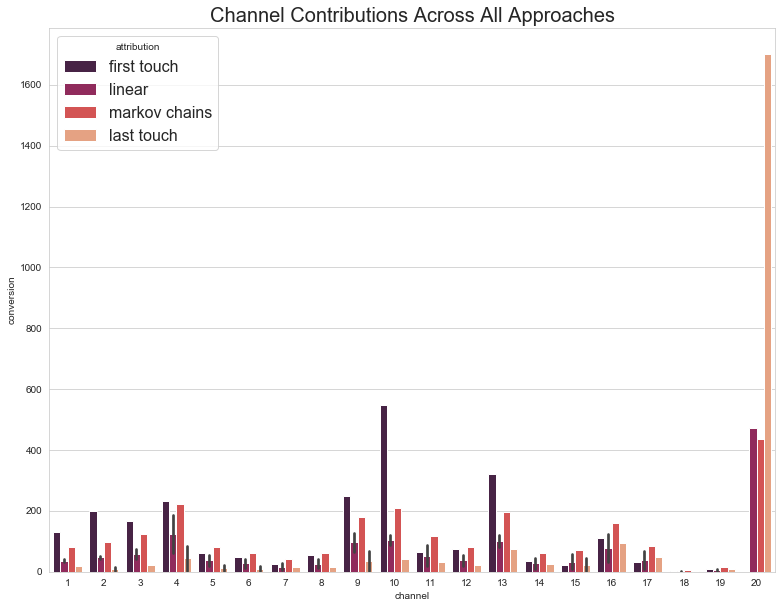

In [108]:
# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=16)
fig, ax = plt.subplots(figsize=(13, 10))
sns.barplot(x='channel', y='conversion', hue='attribution', data=channel_total, palette="rocket")
plt.title('Channel Contributions Across All Approaches', fontsize=20)
plt.show()

### Transition Matrix

In [149]:
transition = pd.read_csv('Markov-Output-Transition-Matrix.csv')
transition.head()

,channel_from,channel_to,transition_probability
0,(start),1,0.054348
1,(start),10,0.228679
2,(start),11,0.027592
3,(start),12,0.031355
4,(start),13,0.133779


In [166]:
transition['transition_probability'] = transition['transition_probability'].astype(float)
transition['channel_from'] = transition['channel_from'].replace('(start)', '0').astype(int)
transition['channel_to'] = transition['channel_to'].replace('(conversion)', '21').astype(int)
channels_from = np.sort(transition['channel_from'].unique())
channels_to = np.sort(transition['channel_to'].unique())
transition_matrix = pd.DataFrame(columns=channels_to, index=channels_from)

for fr in channels_from:
    for to in channels_to:
        prob = transition.loc[(transition['channel_from']==fr)
                              &(transition['channel_to']==to)]['transition_probability'].values
        if len(prob) > 0:
            transition_matrix.loc[fr][to] = prob[0]
        else:
            transition_matrix.loc[fr][to] = 0 

transition_matrix = transition_matrix.rename(index={0:'start'}, columns={21:'conversion'})
transition_matrix = transition_matrix.apply(pd.to_numeric)

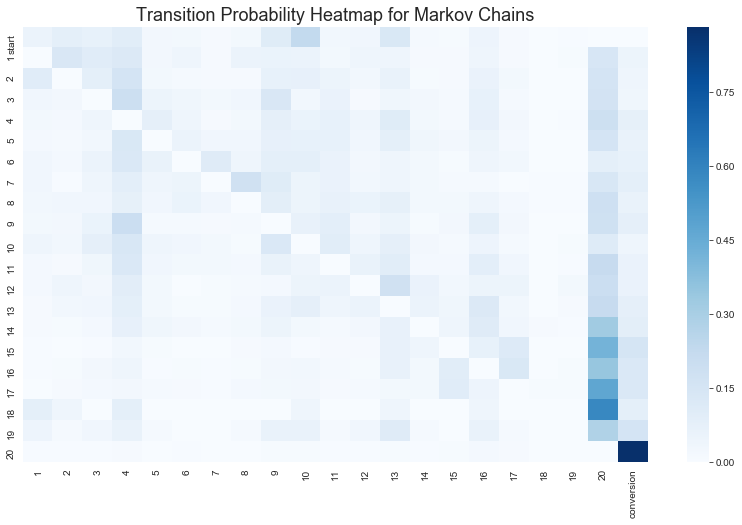

In [182]:
# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(transition_matrix, cmap="Blues")
plt.title('Transition Probability Heatmap for Markov Chains', fontsize=18)
plt.show()

#### Reference

https://medium.com/@mortenhegewald/marketing-channel-attribution-using-markov-chains-101-in-python-78fb181ebf1e